<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [1]:
import pandas as pd 
import numpy as np 
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import re
from datetime import datetime, date, time, timezone, timedelta 

from collections import defaultdict
from functools import reduce 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'mall_customers.csv',
 '1_orders_dataset.csv',
 'ecommerce-data.csv',
 'sales.csv',
 'groceries.csv',
 'sample-sales-data.csv',
 'mock_sales_data.csv',
 'online_retail_II.xlsx',
 'KPMG_VI_New_raw_data_update_final.csv',
 'sales_vs_discount.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 '1_customers_dataset.csv',
 'sales_data_with_stores.csv',
 '1_order_payments_dataset.csv',
 'test.csv',
 'scanner_data.csv',
 'online_retail.xlsx',
 'sample_data']

In [6]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name='Transactions')
df.head()

,Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145


In [7]:
df.columns = df.iloc[0]
df.drop([0], axis = 0, inplace = True)
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [8]:
df = df[df.order_status == 'Approved']
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [9]:
df.transaction_date = pd.to_datetime(df.transaction_date)
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df.transaction_date.to_numpy().astype('datetime64[M]')
df = df[['customer_id', 'date', 'month', 'list_price']]
df.head()


,customer_id,date,month,list_price
1,2950,2017-02-25,2017-02-01,71.49
2,3120,2017-05-21,2017-05-01,2091.47
3,402,2017-10-16,2017-10-01,1793.43
4,3135,2017-08-31,2017-08-01,1198.46
5,787,2017-10-01,2017-10-01,1765.3


In [11]:
df = df.rename(columns = {'customer_id':'id', 'list_price':'rev'})
df.head()

,id,date,month,rev
1,2950,2017-02-25,2017-02-01,71.49
2,3120,2017-05-21,2017-05-01,2091.47
3,402,2017-10-16,2017-10-01,1793.43
4,3135,2017-08-31,2017-08-01,1198.46
5,787,2017-10-01,2017-10-01,1765.3


In [23]:
info_m = df.groupby(['id','month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values='money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').sort_values(['id','month'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,1,1209.08
1,2,0.00
2,3,0.00
3,4,0.00
4,5,1812.75


In [24]:
info_f = df.groupby(['id','month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values='freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').sort_values(['id','freq'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()

,id,freq
0,1,7.0
1,2,3.0
2,3,6.0
3,4,2.0
4,5,4.0


In [25]:
date_max = df['date'].max() + pd.offsets.MonthEnd(0)
date_max

Timestamp('2017-12-31 00:00:00')

In [27]:
info_r = df.groupby(['id']).agg({'date' : lambda x : (date_max - x.max())}).reset_index().rename(columns = {'date':'recency'})
info_r['recency'] = info_r['recency'].dt.days
info_r.head()

,id,recency
0,1,8
1,2,129
2,3,103
3,4,196
4,5,17


In [28]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info.head()

,id,recency,freq,money
0,1,8,7.0,1209.08
1,2,129,3.0,0.00
2,3,103,6.0,0.00
3,4,196,2.0,0.00
4,5,17,4.0,1812.75


In [40]:
info = info.assign(
    r = pd.qcut(info.recency, 5, list('54321')).astype(int),
    f = pd.qcut(info.freq.rank(method = 'first'), 5, list('12345')).astype(int),
    m = pd.qcut(info.freq.rank(method = 'first'), 5, list('12345')).astype(int)
)
info.head()

,id,recency,freq,money,r,f,m
0,1,8,7.0,1209.08,5,5,5
1,2,129,3.0,0.00,1,1,1
2,3,103,6.0,0.00,1,5,5
3,4,196,2.0,0.00,1,1,1
4,5,17,4.0,1812.75,4,2,2


In [56]:
def get_elbow(df) :

  res = []

  for i in range(1, 10) :

    km = KMeans(n_clusters=i)
    km.fit(df)
    res.append(km.inertia_)
  
  plt.plot(range(1, 10), res, marker = 'o')
  plt.show()

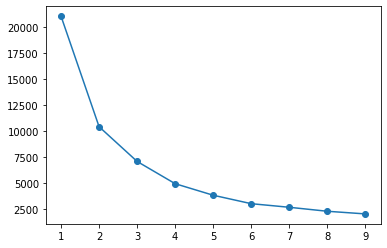

In [57]:
get_elbow(info[['r','f', 'm']]) 

In [53]:
km = KMeans(n_clusters=4)
km.fit(info[['r','f','m']])
info['flag'] = km.fit_predict(info[['r','f','m']]).astype(str)
info.head()

,id,recency,freq,money,r,f,m,flag
0,1,8,7.0,1209.08,5,5,5,2
1,2,129,3.0,0.00,1,1,1,0
2,3,103,6.0,0.00,1,5,5,3
3,4,196,2.0,0.00,1,1,1,0
4,5,17,4.0,1812.75,4,2,2,1


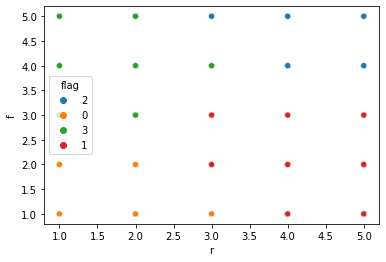

In [54]:
sns.scatterplot(data = info, x = 'r', y = 'f', hue = 'flag')

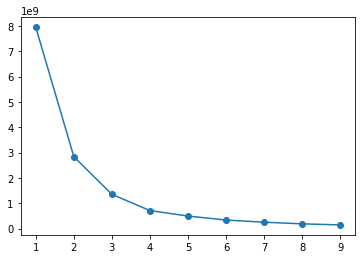

In [59]:
get_elbow(info[['recency','freq', 'money']]) 

In [62]:
km = KMeans(n_clusters=4)
km.fit(info[['recency','freq', 'money']])
info['flag2'] = km.fit_predict(info[['recency','freq', 'money']]).astype(str)
info.head()

,id,recency,freq,money,r,f,m,flag,flag2
0,1,8,7.0,1209.08,5,5,5,2,0
1,2,129,3.0,0.00,1,1,1,0,1
2,3,103,6.0,0.00,1,5,5,3,1
3,4,196,2.0,0.00,1,1,1,0,1
4,5,17,4.0,1812.75,4,2,2,1,0


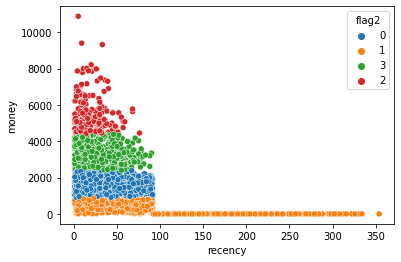

In [64]:
sns.scatterplot(data = info, x = 'recency', y = 'money', hue = 'flag2')

# Iterator

In [65]:
from string import ascii_lowercase as lw
lt = list(lw) + list(range(10))

In [70]:
names = ['park', 'kim', 'yoo']

email1 = [''.join(np.random.choice(lt, 10, replace = True)) for a in range(3)]
email2 = [''.join(np.random.choice(lt, 5, replace = True)) for a in range(3)]
email = [a + '@' + b + np.random.choice(['.com','.net', '.co.kr'], 1)[0] for a, b in zip(email1, email2)]
age = np.random.randint(20, 40, 3)
score = np.random.randint(30, 100, 3)

In [73]:
[{n : list(a)} for n ,a in zip(names, zip(email, age, score))]

[{'park': ['0k5v6c0myu@hoj21.net', 22, 52]},
 {'kim': ['b32cq0xfv5@j6hhv.com', 34, 35]},
 {'yoo': ['3t2sm38yfb@cgzs9.co.kr', 25, 54]}]